# EfficientNetB0 Model for Dermatology Classification

## 1. Import Libraries
----------------------

In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, Input

## 2. Load Data
-----

In [48]:
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [49]:
train_df.describe()

,fitzpatrick_scale,fitzpatrick_centaur,ddi_scale
count,2860.000000,2860.000000,2860.000000
mean,2.524476,2.095455,23.547552
std,1.474428,1.510942,15.530522
min,-1.000000,-1.000000,-1.000000
25%,2.000000,1.000000,12.000000
50%,2.000000,2.000000,12.000000
75%,3.000000,3.000000,34.000000
max,6.000000,6.000000,56.000000


In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860 entries, 0 to 2859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                2860 non-null   object
 1   fitzpatrick_scale      2860 non-null   int64 
 2   fitzpatrick_centaur    2860 non-null   int64 
 3   label                  2860 non-null   object
 4   nine_partition_label   2860 non-null   object
 5   three_partition_label  2860 non-null   object
 6   qc                     90 non-null     object
 7   ddi_scale              2860 non-null   int64 
 8   file_path              2860 non-null   object
dtypes: int64(3), object(6)
memory usage: 201.2+ KB


In [51]:
print(train_df.head())

                                md5hash  fitzpatrick_scale  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                  4   
1  a4bb4e5206c4e89a303f470576fc5253.jpg                  1   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                  5   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg                  3   
4  c77d6c895f05fea73a8f3704307036c0.jpg                  1   

   fitzpatrick_centaur                             label nine_partition_label  \
0                    4                 prurigo-nodularis     benign-epidermal   
1                    1  basal-cell-carcinoma-morpheiform  malignant-epidermal   
2                    5                            keloid         inflammatory   
3                    3              basal-cell-carcinoma  malignant-epidermal   
4                    1                 prurigo-nodularis     benign-epidermal   

  three_partition_label            qc  ddi_scale  \
0                benign           NaN         34   
1             malignant           Na

In [52]:
print("Columns:", train_df.columns.tolist())

Columns: ['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label', 'nine_partition_label', 'three_partition_label', 'qc', 'ddi_scale', 'file_path']


In [53]:
# Value counts for relevant columns
cols_to_check = [
    'fitzpatrick_scale', 'fitzpatrick_centaur', 'qc',
    'nine_partition_label', 'three_partition_label', 'ddi_scale', 'label'
]
for col in cols_to_check:
    print(f"Value counts for {col}:")
    print(train_df[col].value_counts())
    print("")

Value counts for fitzpatrick_scale:
fitzpatrick_scale
 2    964
 3    562
 1    528
 4    393
 5    216
-1    108
 6     89
Name: count, dtype: int64

Value counts for fitzpatrick_centaur:
fitzpatrick_centaur
 1    1000
 2     730
 3     489
 4     253
-1     161
 5     147
 6      80
Name: count, dtype: int64

Value counts for qc:
qc
1 Diagnostic          76
5 Potentially          7
3 Wrongly labelled     4
2 Characteristic       2
4 Other                1
Name: count, dtype: int64

Value counts for nine_partition_label:
nine_partition_label
inflammatory                    1017
malignant-epidermal              900
malignant-melanoma               342
benign-epidermal                 231
benign-dermal                    134
malignant-cutaneous-lymphoma     127
malignant-dermal                 109
Name: count, dtype: int64

Value counts for three_partition_label:
three_partition_label
malignant         1478
non-neoplastic    1017
benign             365
Name: count, dtype: int64

Value c

## 3. Exploratory Data Analysis
------

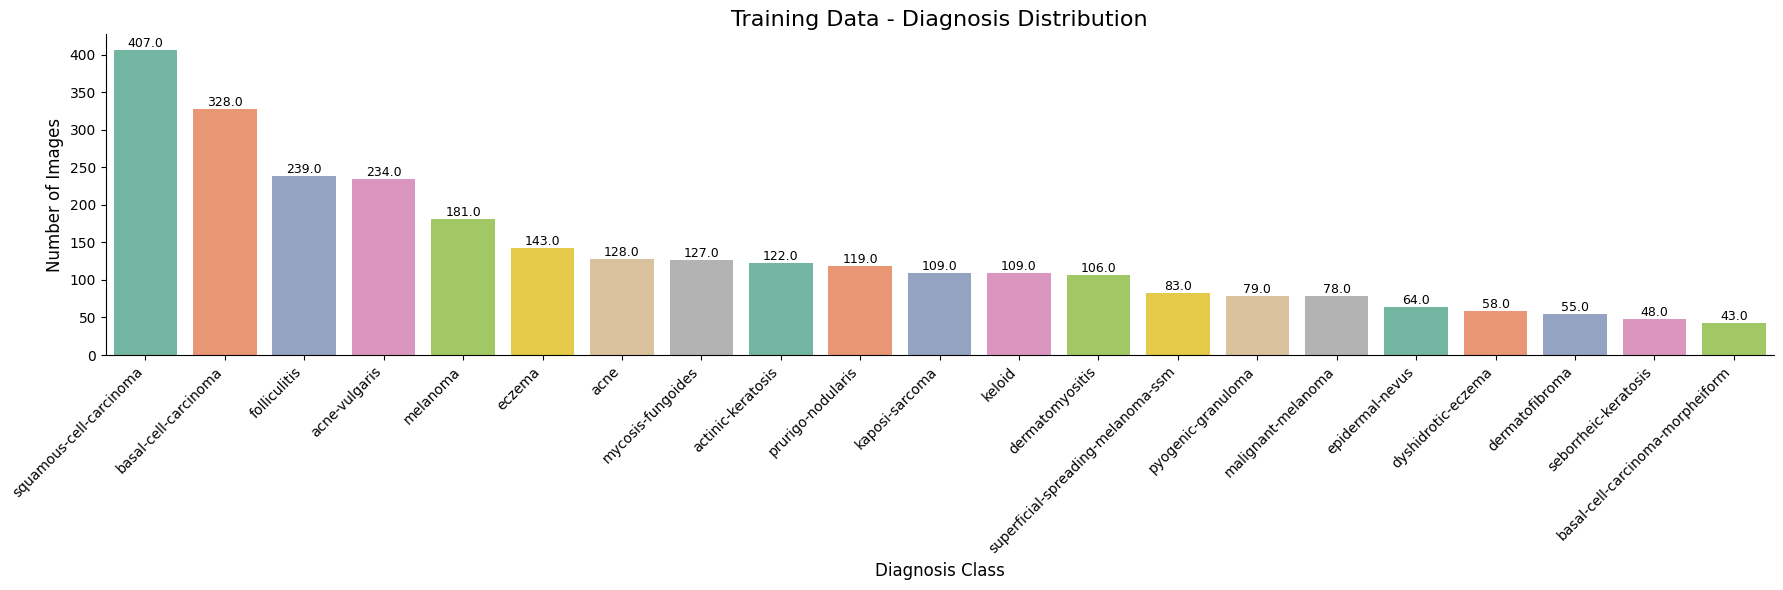

In [64]:
plt.figure(figsize=(18, 6))
ax = sns.countplot(
    data=train_df,
    x='label',
    order=train_df['label'].value_counts().index,
    palette='Set2'
)
plt.title('Training Data - Diagnosis Distribution', fontsize=16)
plt.xlabel('Diagnosis Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), ','), (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='bottom', fontsize=9)
sns.despine()
plt.tight_layout()
plt.show()

### Visualize Three Partition Label Distribution

<ipython-input-55-2d486568e3e1>:12: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


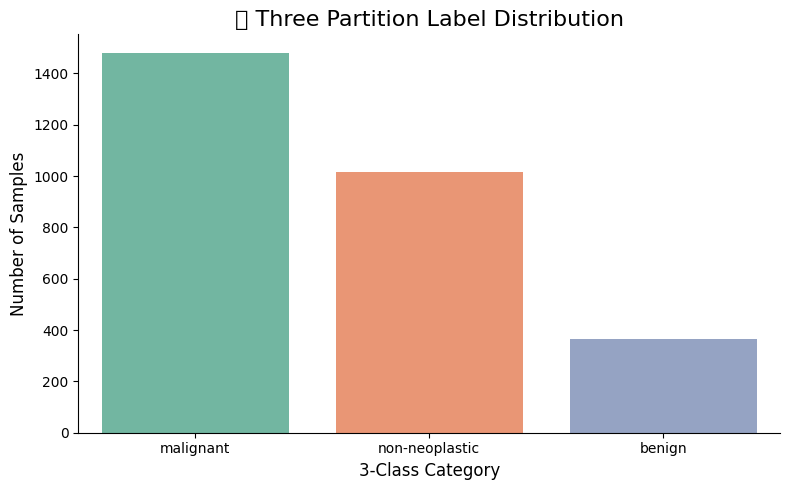

In [55]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=train_df,
    x='three_partition_label',
    order=train_df['three_partition_label'].value_counts().index,
    palette='Set2'
)
plt.title('🧪 Three Partition Label Distribution', fontsize=16)
plt.xlabel('3-Class Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

### Visualize QC vs Fitzpatrick Scale

<ipython-input-56-2612bf181e33>:13: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


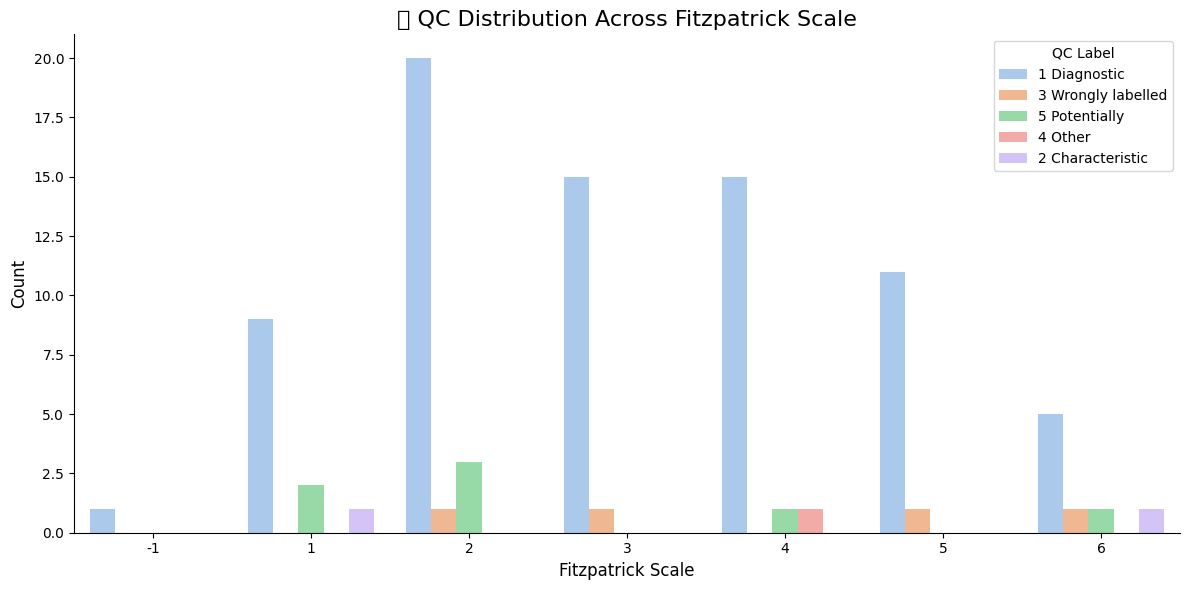

In [56]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=train_df,
    x='fitzpatrick_scale',
    hue='qc',
    palette='pastel'
)
plt.title('🎯 QC Distribution Across Fitzpatrick Scale', fontsize=16)
plt.xlabel('Fitzpatrick Scale', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='QC Label')
sns.despine()
plt.tight_layout()
plt.show()

## 4. Encode Labels & Prepare Dataset
-----

In [57]:
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

img_size = (224, 224)
batch_size = 32
data_dir = "/kaggle/input/bttai-ajl-2025/train/train/"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 2860 files belonging to 21 classes.
Using 2288 files for training.
Found 2860 files belonging to 21 classes.
Using 572 files for validation.


### 9 sample images

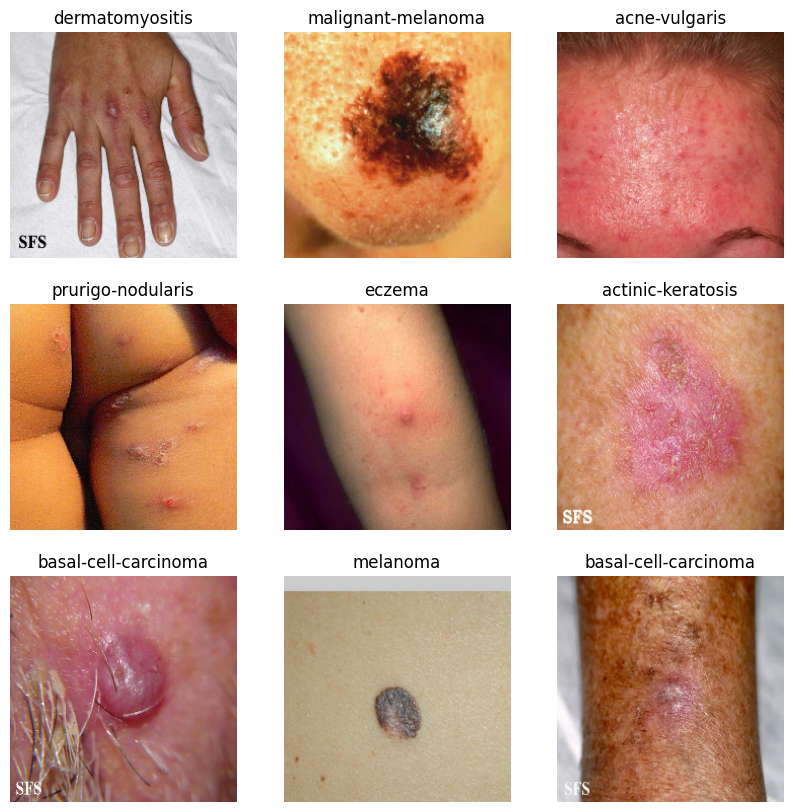

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 5. Build EfficientNetB0 Model

In [59]:
base_model = EfficientNetB0(include_top=False, input_shape=img_size + (3,), weights='imagenet', pooling='avg')
base_model.trainable = False

inputs = Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes)(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## 6. Train Model
-----

In [60]:
epochs = 5
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.1727 - loss: 2.8289 - val_accuracy: 0.2657 - val_loss: 2.3211
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.3732 - loss: 2.0992 - val_accuracy: 0.3444 - val_loss: 2.1168
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4387 - loss: 1.8491 - val_accuracy: 0.3759 - val_loss: 2.0102
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4657 - loss: 1.7357 - val_accuracy: 0.3759 - val_loss: 1.9563
Epoch 5/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5263 - loss: 1.5783 - val_accuracy: 0.4108 - val_loss: 1.8906


## 7. Classification Report
-----

In [61]:
y_true, y_pred = [], []
for images, labels in val_ds:
    logits = model.predict(images)
    predictions = np.argmax(logits, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
                                    precision    recall  f1-score   support

                              acne       0.13      0.08      0.10        24
                     acne-vulgaris       0.41      0.74      0.53        35
                 actinic-keratosis       0.36      0.20      0.26        20
              basal-cell-carcinoma       0.41  

## 8. Make Predictions on Test Data
------

In [62]:
def preprocess_test_data(test_df, directory):
    from tensorflow.keras.utils import load_img, img_to_array
    test_images = []
    for row in test_df.itertuples():
        img_path = os.path.join(directory, row.md5hash)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        test_images.append(img_array)
    return np.array(test_images)

test_images = preprocess_test_data(test_df, "/kaggle/input/bttai-ajl-2025/test/test")

## 9. Generate Predictions
-------

In [65]:
preds = model.predict(test_images)
pred_labels = np.argmax(preds, axis=1)

# Convert to actual class names
# Remove .jpg before saving to match expected format
test_df['md5hash'] = test_df['md5hash'].str.replace('.jpg', '', regex=False)
test_df['predicted_label'] = label_encoder.inverse_transform(pred_labels)
test_df[['md5hash', 'predicted_label']].to_csv('submission.csv', index=False)

39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step
